In [5]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  FOLDERNAME = 'Projet_dep'
  %cd /content/gdrive/My\ Drive/$FOLDERNAME
except ImportError:
  pass

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/16TS1RsIeHZ8iSQtU65AMxP3pEU4cwkPx/Projet_dep


In [3]:
import os
import numpy as np
import skimage.io as io
from pathlib import Path
import numpy as np
import cv2
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from google.colab.patches import cv2_imshow
import torch.optim as optim
import torch
import torchvision.models

In [30]:
USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial
device = torch.device('cuda') if (USE_GPU and torch.cuda.is_available()) else torch.device('cpu')

In [31]:
folder_path = "label_db"
N = 0
for path, dirs, files in os.walk(folder_path):
    N = len(files)
n = int(N/5)
print_every = 100

In [33]:
dataset = []
folder_path_img = "image_db/"
folder_path_label = "label_db/"

In [34]:
for i in range(1,n+1):
    #print(i)
    img_name = "X" + str(i) + ".jpg"
    label_name = "label" + str(i) + ".npy"
    img = cv2.imread(folder_path_img + img_name)
    label = np.load(folder_path_label + label_name)
    dataset.append((img,label))

In [35]:
for i in range(1,n+1):
    #print(i)
    img_name = "X" + str(i) + "_flipped.jpg"
    label_name = "label" + str(i) + "_flipped.npy"
    img = cv2.imread(folder_path_img + img_name)
    label = np.load(folder_path_label + label_name)
    dataset.append((img,label))

In [36]:
for i in range(1,n+1):
    #print(i)
    img_name = "X" + str(i) + "_rotated.jpg"
    label_name = "label" + str(i) + "_rotated.npy"
    img = cv2.imread(folder_path_img + img_name)
    label = np.load(folder_path_label + label_name)
    dataset.append((img,label))

In [37]:
for i in range(1,n+1):
    #print(i)
    img_name = "X" + str(i) + "_noisy.jpg"
    label_name = "label" + str(i) + "_noisy.npy"
    img = cv2.imread(folder_path_img + img_name)
    label = np.load(folder_path_label + label_name)
    dataset.append((img,label))

In [38]:
for i in range(1,n+1):
    #print(i)
    img_name = "X" + str(i) + "_shifted.jpg"
    label_name = "label" + str(i) + "_shifted.npy"
    img = cv2.imread(folder_path_img + img_name)
    label = np.load(folder_path_label + label_name)
    dataset.append((img,label))

In [39]:
dataset = np.asarray(dataset)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [40]:
NUM_TRAIN = 49000
loader_train = DataLoader(dataset, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(dataset, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

dataloaders = {
  'train': loader_train,
  'val': loader_val
}

In [41]:
def random_split(dataset, percentage = 0.8):
  N = len(dataset)
  perm = np.random.permutation(N)
  perm = np.asarray(perm)
  N_train = int(N*percentage)
  dataset = np.asarray(dataset)
  dataset_train = dataset[perm[0:N_train]]
  dataset_val = dataset[perm[N_train:]]
  return dataset_train, dataset_val

In [42]:
def check_accuracy(dataset, model):  
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x,y in dataset:
            x = torch.from_numpy(x)
            y = y.astype(float)
            y = troch.from_numpy(y)
            x = x.to(device=device, dtype=dtype) # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            ######################################
            # START code block: write code below
            ######################################
            scores = model(x)
            for i in range(x.shape[0]):
              num_samples += 1
              pred = torch.argmax(scores[i,])
              if pred == y[i]:
                num_correct += 1
            ######################################
            # END code block
            ######################################

        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    
def run_val(dataset, model):
    model.eval()
    loss = 0
    with torch.no_grad():
        for x, y in dataset:
            x = torch.from_numpy(x)
            y = y.astype(float)
            y = troch.from_numpy(y)
            x = x.to(device=device, dtype=dtype) # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            scores = model(x)
            l = F.cross_entropy(scores, y)
            loss += l
            ######################################
            # START code block: write code below
            ######################################


            ######################################
            # END code block
            ######################################

    return loss/len(dataset)

def train_module(model, optimizer, dataset,epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: the loss values at specific iterations
    """
    losses = {}
    losses_val = {}
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    dataset_train, dataset_val = random_split(dataset) 
    for e in range(epochs):
        for t,(x,y) in enumerate(dataset_train):
            model.train()  # put model to training mode
            x = torch.from_numpy(x)
            y = y.astype(float)
            y = torch.from_numpy(y)
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                losses[e * len(dataset_train) + t] = loss.item()
                check_accuracy(dataset_val, model)
                print()
        
        loss_val = run_val(loader_val, model)
        losses_val[(e + 1) * len(loader_train)] = loss_val.item()

    return losses, losses_val

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F




class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)

    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3, 64, 128, 256, 512, 1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i + 1]) for i in range(len(chs) - 1)])
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs = chs
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i + 1], 2, 2) for i in range(len(chs) - 1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i + 1]) for i in range(len(chs) - 1)])

    def forward(self, x, encoder_features):
        for i in range(len(self.chs) - 1):
            x = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x = torch.cat([x, enc_ftrs], dim=1)
            x = self.dec_blocks[i](x)
        return x

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(3, 64, 128, 256, 512, 1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1,
                 retain_dim=False, out_sz=(572, 572)):
        super().__init__()
        self.encoder = Encoder(enc_chs)
        self.decoder = Decoder(dec_chs)
        self.head = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [49]:
def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = flatten(self.conv_last(x))

    return out

In [69]:
def test(model):
    hidden_layer_size = 42
    x = torch.zeros((64, 3,512,512), device = device,dtype=dtype)  # minibatch size 64, feature dimension 50
    scores = model(x)
    print(scores.size())  # you should see [64, 10]

In [70]:
test(model)

RuntimeError: ignored

In [28]:
def float_to_uint8(img, multiply_channel=False):
  if multiply_channel:
    return (255*np.stack((img,)*3, axis=-1)).astype(np.uint8)
  return (255*img).astype(np.uint8)

def print_heatmap(heatmap):
  io.imshow(cv2.GaussianBlur(float_to_uint8(heatmap),(21,21),5.0))

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


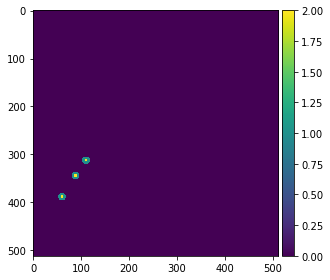

In [29]:
label = np.load("label_db/label11.npy")
img = print_heatmap(label[1])


In [57]:
num_class = 8
model = UNet(num_class = num_class).to(device)

In [ ]:
optimizer_ft = optim.Adam(model.parameters(),lr=1e-3, weight_decay = 1e-6)
model = train_module(model, optimizer_ft, dataset = dataset, epochs=1)